# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run114', 'ORACLE.run120', 'ORACLE.run144', 'ORACLE.run126', 'ORACLE.run18', 'ORACLE.run132', 'ORACLE.run138', 'ORACLE.run150'}


{'Wisig_3', 'Wisig_1', 'Wisig_4', 'Wisig_2'}


tensor([[[ 1.1692, -0.3795, -0.5538,  ..., -0.5641, -0.6872, -2.2051],
         [ 0.2359,  0.6974,  0.7385,  ..., -0.0205, -0.3487, -0.2359]],

        [[-0.1891,  0.2521, -0.2732,  ...,  0.1471, -0.3782, -0.5778],
         [ 0.4097,  0.5148, -1.3973,  ...,  0.4202,  0.2521,  0.3572]],

        [[ 0.3558, -0.1423,  0.0102,  ..., -0.7014, -0.4270, -0.7014],
         [-0.9759,  0.0915,  0.4778,  ..., -0.5795, -0.8539,  0.8743]],

        ...,

        [[ 1.1792,  0.5177,  1.3086,  ..., -0.4746, -0.5608, -0.3308],
         [-0.3883,  0.9132,  0.5824,  ..., -0.7837,  1.8695,  1.7904]],

        [[-0.1060,  1.3495,  0.0353,  ..., -0.7066, -0.1978, -0.1413],
         [-0.1554, -0.5441, -1.4131,  ..., -1.3001, -0.1272,  0.1908]],

        [[-0.5448, -1.1828, -0.7455,  ...,  0.0645, -0.8889,  0.3298],
         [ 0.2437,  0.1577, -0.1720,  ...,  0.0143,  0.6308, -1.0323]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.9837, train_label_loss: 2.7719, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2959.5383, train_label_loss: 2.7658, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3045.4359, train_label_loss: 1.4396, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2965.9600, train_label_loss: 1.6737, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2963.0393, train_label_loss: 2.1454, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3002.4623, train_label_loss: 1.6055, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3151.9762, train_label_loss: 1.3321, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3413.7674, train_label_loss: 0.9546, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3475.2023, train_label_loss: 0.8435, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3541.6240, train_label_loss: 1.6996, 


epoch: 1, source_val_acc_label: 0.5318, target_val_acc_label: 0.6206, source_val_label_loss: 1.2631, target_val_label_loss: 6.5536, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.5969, train_label_loss: 0.5604, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3723.2551, train_label_loss: 0.8967, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3771.9302, train_label_loss: 0.8482, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 4426.6424, train_label_loss: 0.6624, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 4962.4180, train_label_loss: 0.9831, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 4363.9581, train_label_loss: 0.9812, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 4041.0370, train_label_loss: 0.9250, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3857.1441, train_label_loss: 1.5230, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3942.0981, train_label_loss: 1.2545, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3879.8562, train_label_loss: 1.0475, 


epoch: 2, source_val_acc_label: 0.5877, target_val_acc_label: 0.6542, source_val_label_loss: 1.0915, target_val_label_loss: 6.5963, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 3.9464, train_label_loss: 1.4064, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3871.0607, train_label_loss: 0.7652, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3986.1735, train_label_loss: 0.7947, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3641.5568, train_label_loss: 0.4297, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2976.4016, train_label_loss: 0.9209, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2993.5414, train_label_loss: 1.5155, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3004.9079, train_label_loss: 1.2958, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2967.0259, train_label_loss: 0.5380, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3041.1741, train_label_loss: 0.4959, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2925.5925, train_label_loss: 0.7272, 


epoch: 3, source_val_acc_label: 0.6010, target_val_acc_label: 0.6677, source_val_label_loss: 1.0535, target_val_label_loss: 7.6036, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.7519, train_label_loss: 0.9375, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3456.1615, train_label_loss: 0.5919, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3540.7198, train_label_loss: 1.1580, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2989.3038, train_label_loss: 1.3630, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2991.5170, train_label_loss: 0.6954, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3041.6812, train_label_loss: 0.5350, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2996.5250, train_label_loss: 1.1892, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2942.0982, train_label_loss: 0.9575, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3033.7154, train_label_loss: 0.9904, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2973.8261, train_label_loss: 0.7290, 


epoch: 4, source_val_acc_label: 0.6002, target_val_acc_label: 0.6650, source_val_label_loss: 1.0827, target_val_label_loss: 8.8382, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.8502, train_label_loss: 0.4838, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3600.2402, train_label_loss: 0.4680, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2995.1487, train_label_loss: 1.0547, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3011.7127, train_label_loss: 1.1760, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2993.3729, train_label_loss: 0.7148, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3048.3993, train_label_loss: 0.6135, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2966.5838, train_label_loss: 0.7561, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2948.6443, train_label_loss: 0.6796, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2998.0783, train_label_loss: 0.8749, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2995.9091, train_label_loss: 0.3358, 


epoch: 5, source_val_acc_label: 0.6006, target_val_acc_label: 0.6642, source_val_label_loss: 1.1277, target_val_label_loss: 10.0909, 


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.9808, train_label_loss: 0.7280, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3115.5168, train_label_loss: 1.1893, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3004.1083, train_label_loss: 0.8470, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3015.7892, train_label_loss: 0.3271, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2957.5508, train_label_loss: 0.4105, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3365.7180, train_label_loss: 0.1875, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3410.9524, train_label_loss: 0.7473, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3412.5711, train_label_loss: 0.8018, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3441.0151, train_label_loss: 0.6261, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3398.1712, train_label_loss: 0.4691, 


epoch: 6, source_val_acc_label: 0.6010, target_val_acc_label: 0.6840, source_val_label_loss: 1.1692, target_val_label_loss: 10.8976, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.0986, train_label_loss: 0.3386, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3445.2117, train_label_loss: 0.7335, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3031.9579, train_label_loss: 0.7286, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3013.3239, train_label_loss: 1.0489, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3007.6527, train_label_loss: 0.4539, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3004.1140, train_label_loss: 0.6375, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3014.6022, train_label_loss: 0.4958, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2969.1361, train_label_loss: 0.2976, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2985.3241, train_label_loss: 0.3600, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2990.1175, train_label_loss: 0.4629, 


epoch: 7, source_val_acc_label: 0.5996, target_val_acc_label: 0.6792, source_val_label_loss: 1.2370, target_val_label_loss: 12.1046, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 3.1963, train_label_loss: 0.6508, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2968.7995, train_label_loss: 0.6886, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2971.6849, train_label_loss: 0.7464, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2968.3916, train_label_loss: 0.3697, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2957.1459, train_label_loss: 0.3927, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2963.4444, train_label_loss: 0.7326, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2962.5222, train_label_loss: 0.5440, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3009.9359, train_label_loss: 0.5384, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2984.9621, train_label_loss: 0.4072, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3293.1138, train_label_loss: 0.3979, 


epoch: 8, source_val_acc_label: 0.5992, target_val_acc_label: 0.6759, source_val_label_loss: 1.3347, target_val_label_loss: 13.8226, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.1894, train_label_loss: 0.7040, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2987.1974, train_label_loss: 0.1157, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3017.3608, train_label_loss: 0.2072, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2991.6444, train_label_loss: 0.1357, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2985.9399, train_label_loss: 0.2988, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3056.2958, train_label_loss: 0.5668, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2992.0127, train_label_loss: 0.5535, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2945.1047, train_label_loss: 0.1211, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3033.4564, train_label_loss: 0.2089, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3450.1194, train_label_loss: 0.1774, 


epoch: 9, source_val_acc_label: 0.5960, target_val_acc_label: 0.6851, source_val_label_loss: 1.4231, target_val_label_loss: 15.0842, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 3.2136, train_label_loss: 0.5448, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3434.2205, train_label_loss: 0.1947, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3421.5556, train_label_loss: 0.5561, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3399.4504, train_label_loss: 0.0939, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3383.7863, train_label_loss: 0.5331, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3431.5025, train_label_loss: 0.2976, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3643.7586, train_label_loss: 0.0725, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3923.6164, train_label_loss: 0.1858, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 4059.2803, train_label_loss: 0.1314, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3973.3717, train_label_loss: 0.0155, 


epoch: 10, source_val_acc_label: 0.5958, target_val_acc_label: 0.6994, source_val_label_loss: 1.5075, target_val_label_loss: 15.9785, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 3.8665, train_label_loss: 0.6523, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3982.4511, train_label_loss: 0.1601, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 4413.3589, train_label_loss: 0.2239, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3787.6364, train_label_loss: 0.0697, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3343.7982, train_label_loss: 0.2400, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3370.9923, train_label_loss: 0.2457, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3544.0416, train_label_loss: 0.0744, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3441.7112, train_label_loss: 0.3414, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3417.1901, train_label_loss: 0.0587, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3377.6036, train_label_loss: 0.1701, 


epoch: 11, source_val_acc_label: 0.5996, target_val_acc_label: 0.6895, source_val_label_loss: 1.5630, target_val_label_loss: 17.3030, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.1578, train_label_loss: 0.1976, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3863.3916, train_label_loss: 0.2514, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3713.5753, train_label_loss: 0.3298, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3489.8492, train_label_loss: 0.3823, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3401.7784, train_label_loss: 0.2610, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3397.3883, train_label_loss: 0.2725, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3418.1781, train_label_loss: 0.2014, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3487.6668, train_label_loss: 0.1820, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3498.9672, train_label_loss: 0.1492, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3399.2550, train_label_loss: 0.1533, 


epoch: 12, source_val_acc_label: 0.5955, target_val_acc_label: 0.6964, source_val_label_loss: 1.6537, target_val_label_loss: 18.1813, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.3542, train_label_loss: 0.2026, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3727.9351, train_label_loss: 0.3812, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3332.9560, train_label_loss: 0.2112, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3373.3229, train_label_loss: 0.2706, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3340.2211, train_label_loss: 0.1615, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3370.7726, train_label_loss: 0.1950, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3565.8114, train_label_loss: 0.0460, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3977.9134, train_label_loss: 0.0225, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 4019.6088, train_label_loss: 0.0936, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 4009.8729, train_label_loss: 0.0375, 


epoch: 13, source_val_acc_label: 0.5970, target_val_acc_label: 0.6883, source_val_label_loss: 1.6979, target_val_label_loss: 18.5335, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.2344, train_label_loss: 0.2184, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3865.8295, train_label_loss: 0.1347, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3889.2341, train_label_loss: 0.1598, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3931.3993, train_label_loss: 0.1484, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3963.0779, train_label_loss: 0.4124, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 4023.1570, train_label_loss: 0.6042, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3929.9451, train_label_loss: 0.0252, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3904.0005, train_label_loss: 0.1485, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3877.6840, train_label_loss: 0.2427, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3835.7300, train_label_loss: 0.1255, 


epoch: 14, source_val_acc_label: 0.5882, target_val_acc_label: 0.6928, source_val_label_loss: 1.8271, target_val_label_loss: 19.9798, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

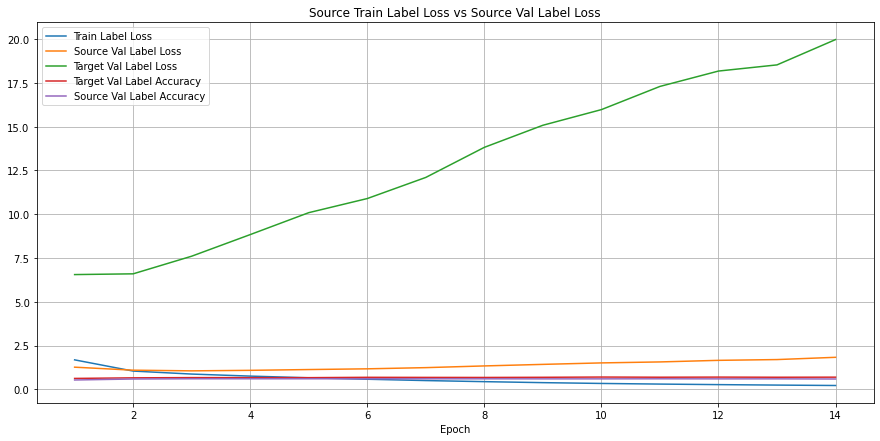

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

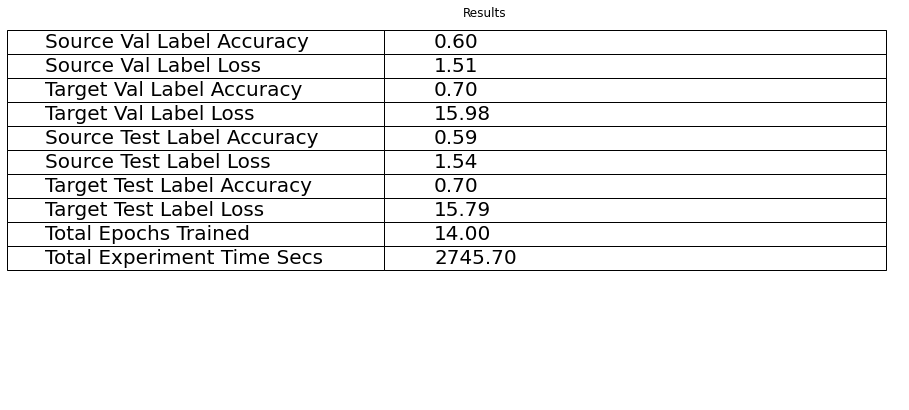

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

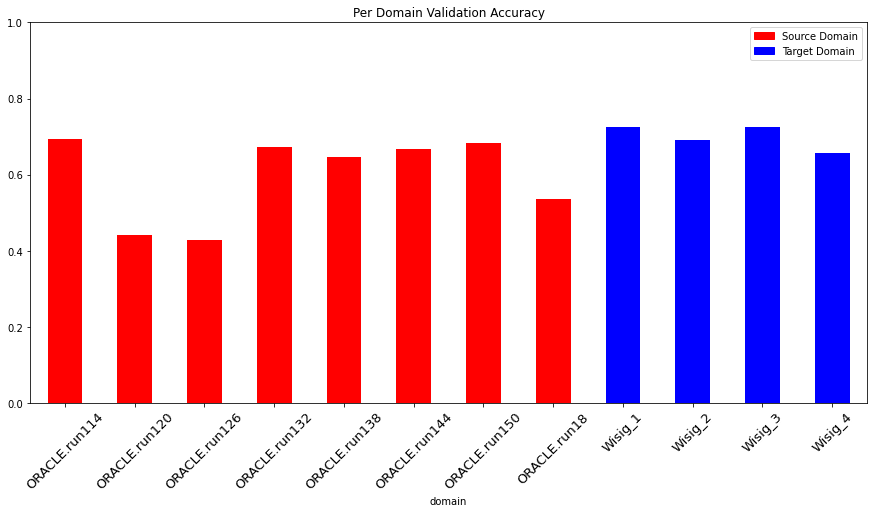

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.58984375 Target Test Label Accuracy: 0.7013673890608875
Source Val Label Accuracy: 0.5957682291666667 Target Val Label Accuracy: 0.699417372881356


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}